In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from dataset import *
random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=50)
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[77.67562 82.52306]


## Train GAMI-Net 

In [4]:
model = GAMINetRegressor(interact_num=50, meta_info=meta_info,
                hidden_layer_sizes_main_effect=[40] * 5, hidden_layer_sizes_interaction=[40] * 5,
                batch_size=1000, activation_func=torch.nn.ReLU(),
                max_epoch_main_effect=1000, max_epoch_interaction=1000, max_epoch_tuning=100,
                learning_rates=[0.0001, 0.0001, 0.0001], early_stop_thres=[10, 10, 10],
                heredity=False, loss_threshold=0.0, reg_clarity=0.1,
                verbose=True, val_ratio=0.2, device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
                random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:   63, train loss: 0.01262: 100%|██████████| 12/12 [00:00<00:00, 128.48it/s]                                               


Epoch:  120, train loss: 0.01256: 100%|██████████| 12/12 [00:00<00:00, 88.33it/s]                                                


Main Effect Training Stop at Epoch: 120, train loss: 0.01256, val loss: 0.01255
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:   63, train loss: 0.00538: 100%|██████████| 12/12 [00:01<00:00,  9.94it/s]                                                


Epoch:  115, train loss: 0.00526: 100%|██████████| 12/12 [00:01<00:00,  9.48it/s]                                                


Interaction Training Stop at Epoch: 115, train loss: 0.00526, val loss: 0.00561
#########################Stage 3: Fine Tuning#########################


Epoch:  37, train loss: 0.00506: 100%|██████████| 12/12 [00:01<00:00,  9.10it/s]                                                 


Fine Tuning Stop at Epoch: 37, train loss: 0.00506, val loss: 0.00542


In [5]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[69.87318 73.60032]


/root/zebin/projects/GAMINet_Pytorch/examples/../gaminet/base.py:874: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim(-absmax, absmax)


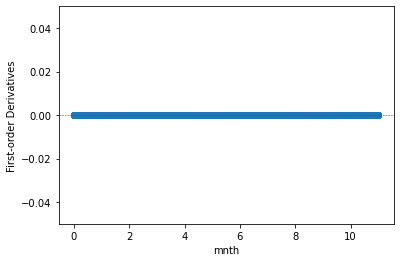

In [6]:
model.partial_derivatives(1)

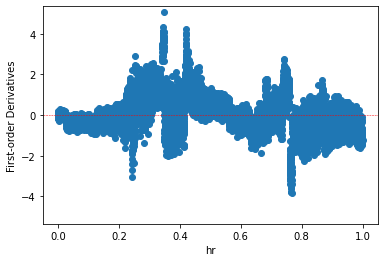

In [7]:
model.partial_derivatives(2)

In [8]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [9]:
model.get_clarity_loss(test_x)

0.0008521754061803222

## Visualization

In [10]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

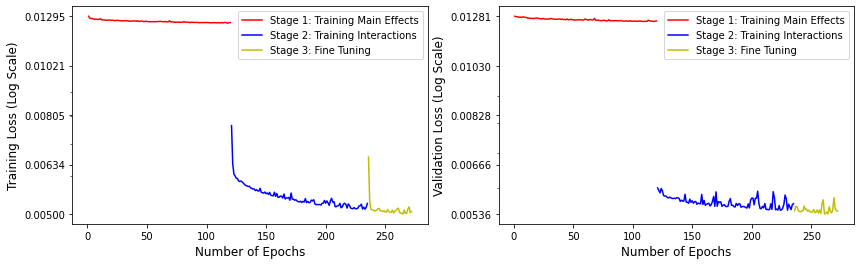

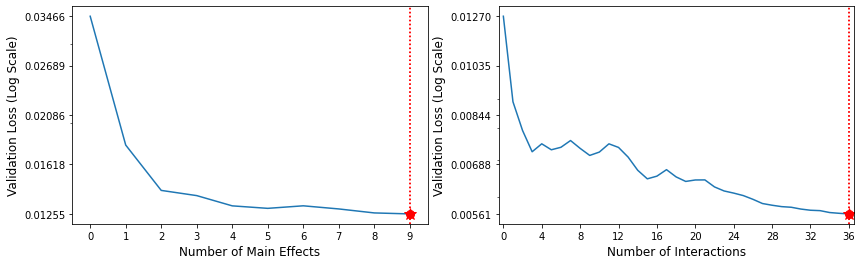

In [11]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

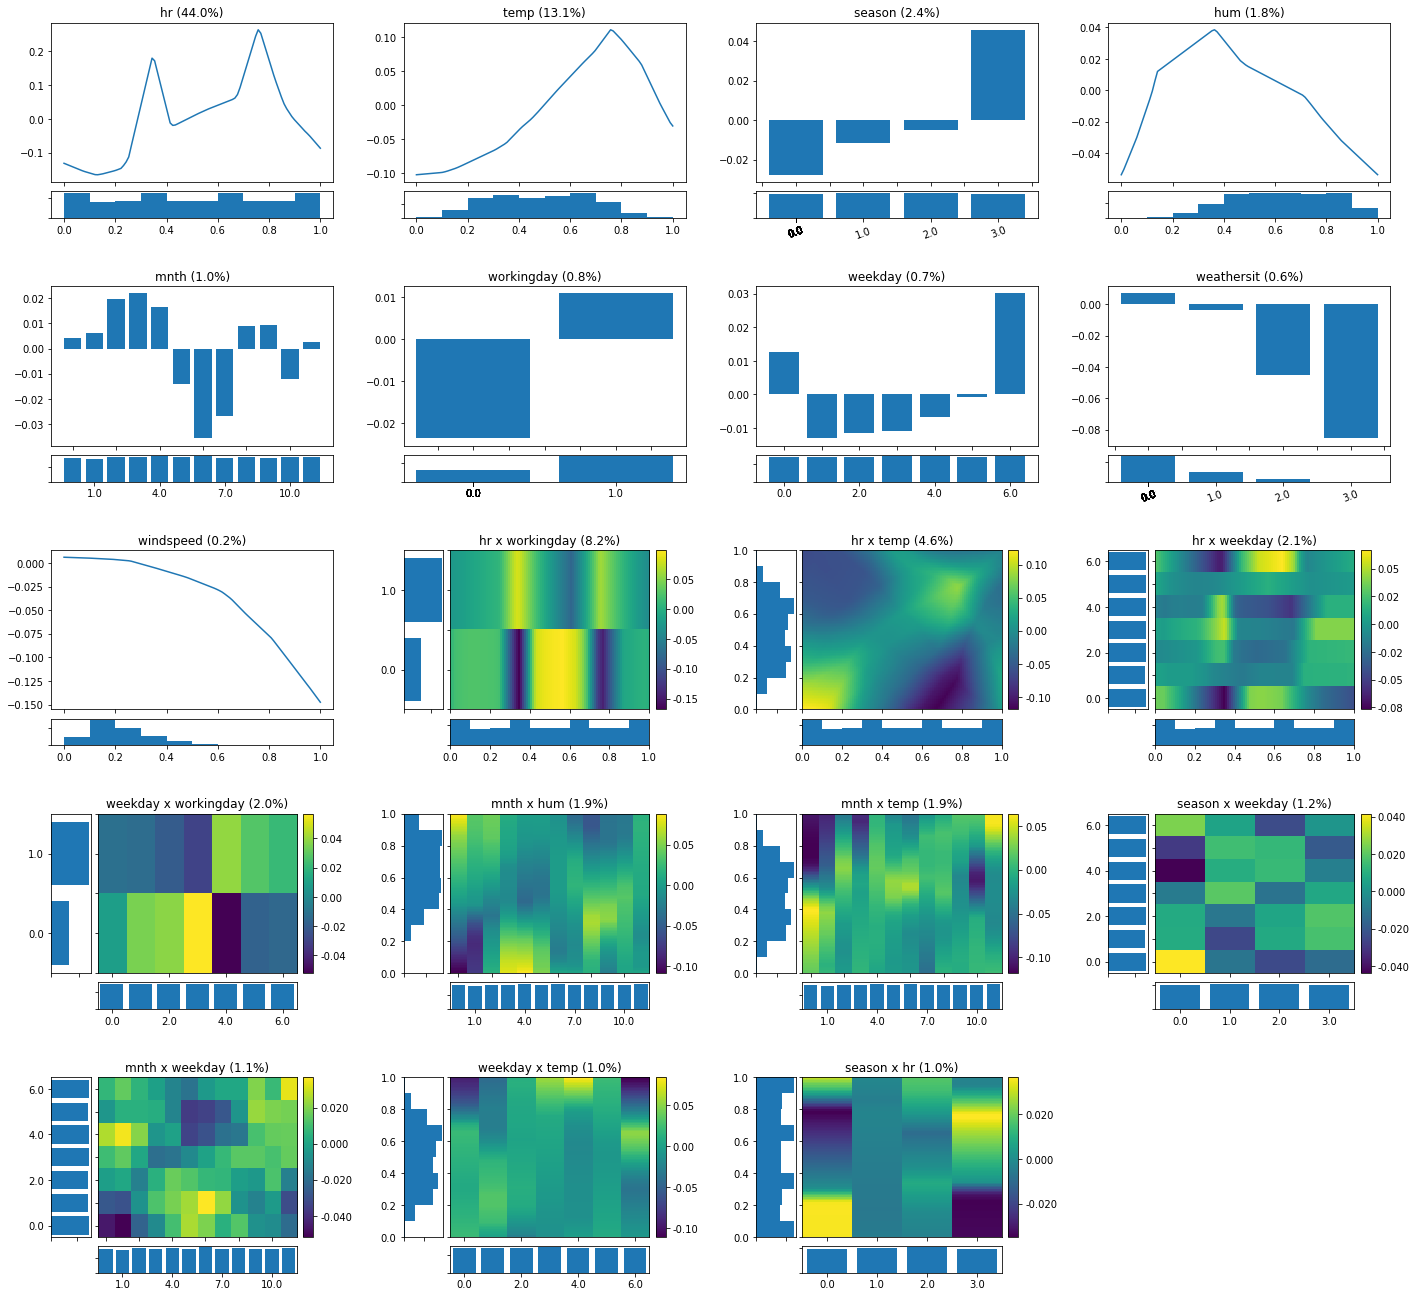

In [12]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=10, interaction_num=10, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

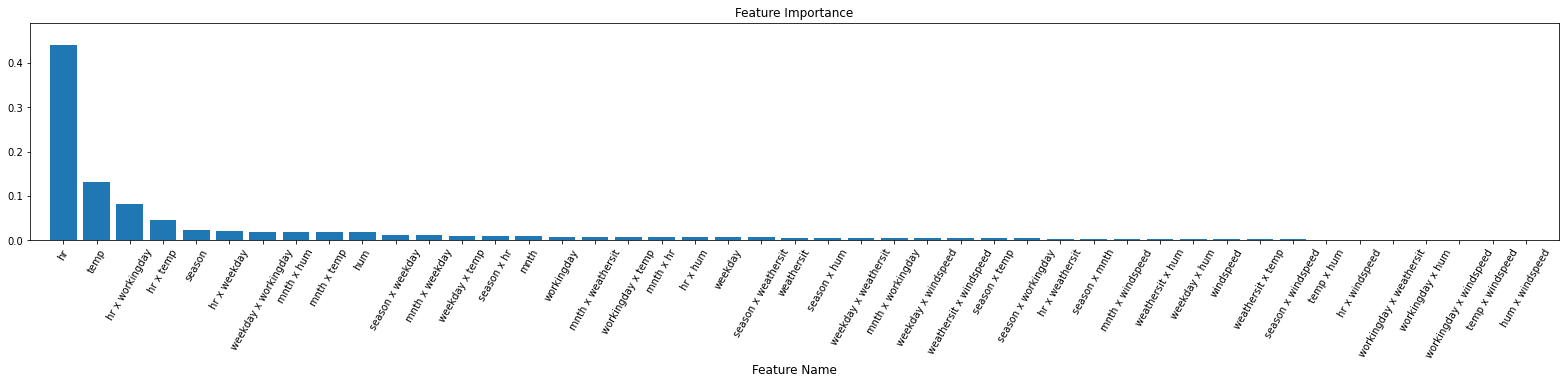

In [13]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [14]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

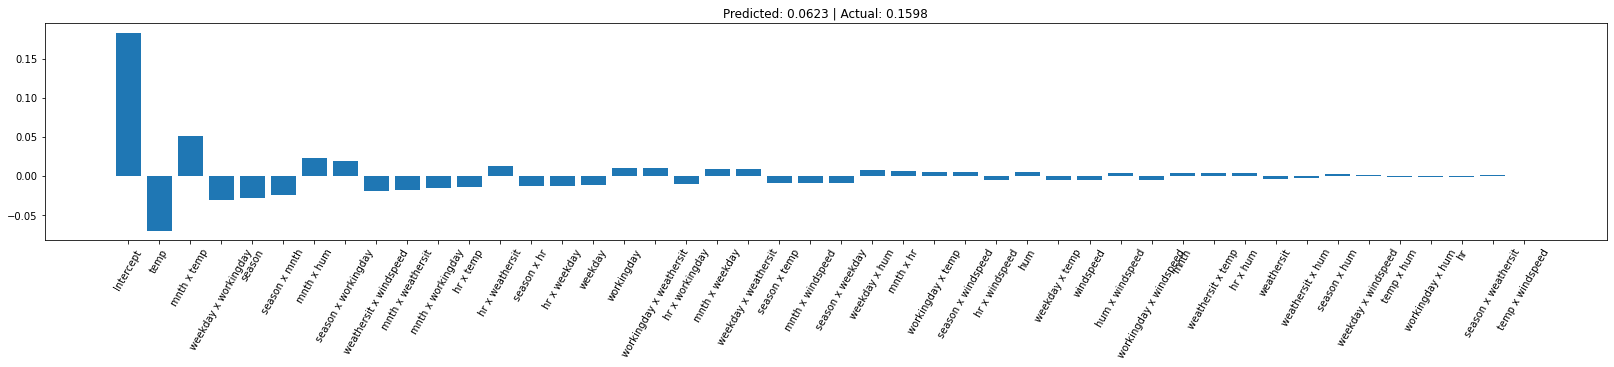

In [15]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [16]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

array([[0.06231802],
       [0.37905487],
       [0.2530601 ],
       ...,
       [0.00074795],
       [0.00449559],
       [0.5606801 ]], dtype=float32)